# Capstone Project: Histopathologic Cancer Detection
Daniel S. Panizzo
February, 2020

### Domain Background

The usage of Neural Networks for image diagnosis is quickly growing in the field of medical research an its usage and efficiency are already being tested on clinics, laboratories and hospitals. With a variety of usage possibilities like cancer detection, classification of lesion types or mental illness, the perspectives are enthusiastics. Recently the Convolutional Neural Networks (CNN) emerged as the most common class of Neural Network for analyzing visual imagery. CNNs are regularized versions of multilayer perceptrons, they take advantage of the hierarquical pattern in data and assemble more complex patterns using smaller and simpler patterns (a.k.a. filtering and pooling the images). This means that a CNN can detect patterns (features) in an image without a pixel losing his correlation with its pixel neighbors. As I have an intense contact with doctors who work with diagnostic imaging and I frequently discuss the use of new technologies in the area, I intend to use this project as a starting point to delve deeper into the subject and perhaps participate in research projects in the area as Machine Learning engineer.

Reference: https://www.researchgate.net/publication/285912467_Artificial_Neural_Networks_in_Medical_Diagnosis

Wikipedia: https://en.wikipedia.org/wiki/Convolutional_neural_network

### Problem Statement

This project is based on the "Histopathologic Cancer Detection" Kaggle Competition, a project to identify metastatic tissue in histopathologic scans of lymph node sections. In others words, identify the presence of tumor cells in digital pathology scans. The expected results of this project is to train a Convolutional Neural Network model to make a binary classification of the presence of tumor (true or false) from a given image.

Reference: https://www.kaggle.com/c/histopathologic-cancer-detection/overview

In [188]:
# Import all libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2 as cv
from glob import glob

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Concatenate, Conv2D, MaxPooling2D, GlobalMaxPooling2D 
from keras.layers import GlobalAveragePooling2D, BatchNormalization, Activation
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint 
from keras import optimizers
from keras.models import Model
from keras.engine.input_layer import Input
from keras.applications.resnet_v2 import ResNet50V2
from keras.applications.densenet import DenseNet201
from keras.applications.nasnet import NASNetMobile

from sklearn.metrics import roc_curve, auc, roc_auc_score

%matplotlib inline

### Datasets and Inputs

In this dataset, we are provided with a large number of small pathology images to classify. Files are named with an image id. The train_labels.csv file provides the ground truth for the images in the train folder. We are predicting the labels for the images in the test folder. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image. The image files have a distribution around 60% for negative labels and 40% for positive labels. Other image features should be analyzed during the exploratory data analysis of the images.

The original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates. We have otherwise maintained the same data and splits as the PCam benchmark.

Reference: https://www.kaggle.com/c/histopathologic-cancer-detection/data

### Load and prepare the data

Before starting our exploratory data analysis, we'll prepare a dataframe to store the image ID, its label (1 or 0), the complete path to access the image, a description of the label ( 0 = False and 1 = True) and a representation of the image as RGB (Red, Green and Blue) pixel values.

In [18]:
# Paths to train, test and model folders
train_folder = '.\\train\\'
test_folder = '.\\test\\'
model_folder = '.\\model\\'

# Prepare a dataframe to store complete path to images and its IDs
df_img = pd.DataFrame({'path': glob(os.path.join(train_folder,'*.tif'))})
df_img['id'] = df_img.path.map(lambda x: x.split('\\')[2].split(".")[0])

# Prepare dataframe with labeled train data
df_train = pd.read_csv('train_labels.csv')

# Join (Merge) dataframes on ID
df = df_train.merge(df_img, on = "id")

# Create a column to describe the label
df['label_desc'] = df['label'].apply(lambda x: 'False' if x == 0 else 'True')

# Create a column to represent the image as RGB arrays 
df['rgb'] = df['path'].apply(lambda x: cv.cvtColor(cv.imread(x), cv.COLOR_BGR2RGB))


In [19]:
# Quick look at our dataframe
df.head(5)

,id,label,path,label_desc,rgb
0,1af50a3d4254999b0b486ee9c4fe1310c87f5b07,0,.\train\1af50a3d4254999b0b486ee9c4fe1310c87f5b...,False,"[[[161, 126, 146], [203, 169, 186], [229, 192,..."
1,1ef450ccba59e14358893b0659b9863ec8b1adf2,0,.\train\1ef450ccba59e14358893b0659b9863ec8b1ad...,False,"[[[228, 211, 217], [232, 219, 228], [220, 210,..."
2,2a88b4c7dc358944bf6791218ddc582082092915,1,.\train\2a88b4c7dc358944bf6791218ddc5820820929...,True,"[[[250, 242, 239], [250, 249, 245], [248, 248,..."
3,2e0bc647a770640e952ba3e824b22a18aa5a37b5,0,.\train\2e0bc647a770640e952ba3e824b22a18aa5a37...,False,"[[[255, 238, 255], [255, 247, 255], [250, 244,..."
4,1fb65b2f6a5ab845545d5157a652e4f7a75c53cd,0,.\train\1fb65b2f6a5ab845545d5157a652e4f7a75c53...,False,"[[[38, 17, 94], [14, 0, 74], [148, 119, 209], ..."


### Exploratory Data Analysis

Let's start taking a look at the positive and negative image samples.

In [4]:
def plot_samples(df):
    """
    Function to plot a set of sample of images.
    Based on the code from Joni Juvonen at:
    https://www.kaggle.com/qitvision/a-complete-ml-pipeline-fast-ai
    
    Args:
        df (dataframe): A dataframe containing one column with the image as RGB array.
    """
    
    # Define the figure's properties
    fig, ax = plt.subplots(2,5, figsize=(20,8))
    fig.suptitle('Histopathologic scans of lymph node sections',fontsize=20)

    # Prepare negative samples
    for i, rgb in enumerate(df[df['label'] == 0]['rgb'][:5]):
        ax[0,i].imshow(rgb)
        # Create a Rectangle patch
        box = patches.Rectangle((32,32),32,32
                               ,linewidth = 4
                               ,edgecolor = 'b'
                               ,facecolor = 'none'
                               ,linestyle = ':'
                               ,capstyle = 'round')
        ax[0,i].add_patch(box)
    ax[0,0].set_ylabel('Negative samples', size='large')

    # Prepare positive samples
    for i, rgb in enumerate(df[df['label'] == 1]['rgb'][:5]):
        ax[1,i].imshow(rgb)
        # Create a Rectangle patch
        box = patches.Rectangle((32,32),32,32
                               ,linewidth = 4
                               ,edgecolor = 'r'
                               ,facecolor = 'none'
                               ,linestyle = ':'
                               ,capstyle = 'round')
        ax[1,i].add_patch(box)
    ax[1,0].set_ylabel('Positive samples', size='large')

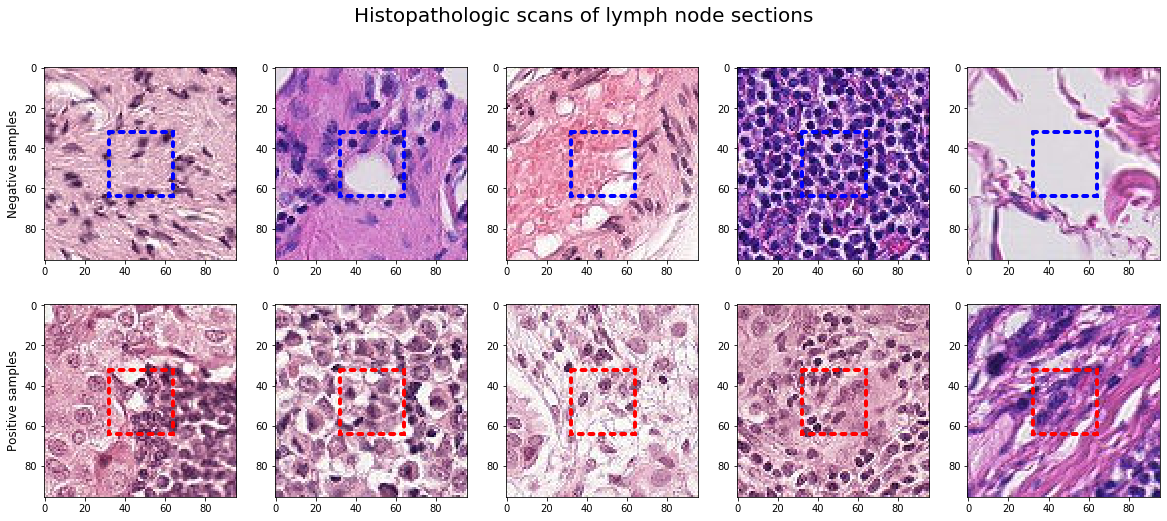

In [5]:
plot_samples(df)

Every image have 96x96px dimensions and the 32x32px center is the area that influences de label (Positive or Negative) for tumor tissue. However the outer area of the image may contain tumor tissue as well.

Now, let's plot the distribution of the image's label.

In [6]:
def plot_label_distribution(df):
    """
    Function to plot the frequency of the label distribution.
    Based on the code from Pablo Gomez at:
    https://www.kaggle.com/gomezp/complete-beginner-s-guide-eda-keras-lb-0-93
    
    Args:
        df (dataframe): A dataframe containing one column with the image label 
                       (Negative == 0 and Positive == 1).
    """
    # Get only the label data
    y = df['label'].copy() 

    # Define the figure's properties
    fig = plt.figure(figsize=(4, 2),dpi=150)

    # Prepare the bar chart data and properties
    plt.bar(y.unique()
           ,[(y == 0).sum()
            ,(y == 1).sum()]
           ); 

    plt.xticks([0,1]
              ,["Negative (N={})".format((y == 0).sum())
               ,"Positive (N={})".format((y == 1).sum())]
              );

    plt.ylabel("# of Samples")

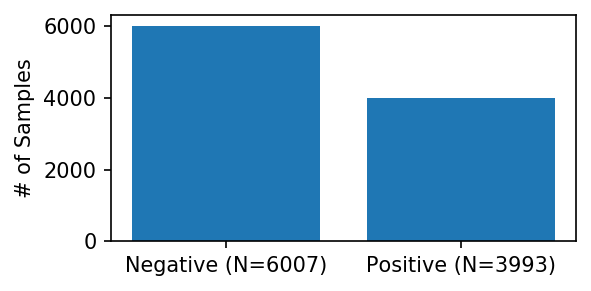

In [7]:
plot_label_distribution(df)

For this project I limited the data to 10.000 images. The distribution is as expected from the original dataset, around 60% for negative samples and 40% for positive samples.

Next we'll explore the pixel value distribution on some sample images.

In [8]:
def plot_pixel_distribution(df):
    """
    Function to plot a histogram of the pixel distribution.
    Based on the code from Pablo Gomez and Matplotlib Tutorial:
    https://www.kaggle.com/gomezp/complete-beginner-s-guide-eda-keras-lb-0-93
    https://matplotlib.org/3.1.1/tutorials/introductory/images.html#sphx-glr-tutorials-introductory-images-py
    
    Args:
        df (dataframe): A dataframe containing one column with image as RGB array
                        and other column with the label (Negative == 0 and Positive == 1)
    
    """
    # Prepare the data 
    positive_samples = df[df['label'] == 1]['rgb'][:100]
    negative_samples = df[df['label'] == 0]['rgb'][:100]
    
    # Define the number of bins 
    # (all possible pixel values)
    bins = 256 
    
    # Define the figure properties
    fig,axs = plt.subplots(1
                          ,2
                          ,sharey = True
                          ,sharex = True
                          ,figsize=(8,2)
                          ,dpi=150)
    
    # Prepare chart data and properties
    axs[0].hist(positive_samples.ravel()
               ,bins = bins
               ,ec = 'k'
               ,density = True)   
    axs[1].hist(negative_samples.ravel()
               ,bins = bins
               ,ec = 'k'
               ,density=True)
    
    # Prepare chart titles and labels
    axs[0].set_title("Positive samples")
    axs[1].set_title("Negative samples")
    axs[0].set_xlabel("Pixel value")
    axs[1].set_xlabel("Pixel value")
    axs[0].set_ylabel("Relative frequency")
    axs[1].set_ylabel("Relative frequency")

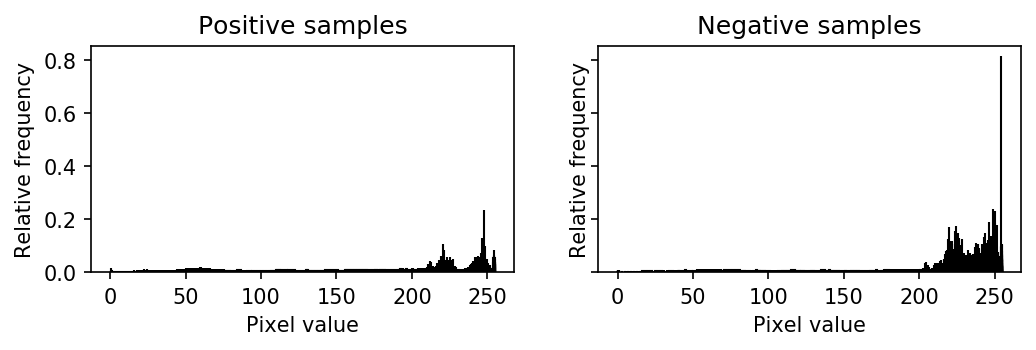

In [9]:
plot_pixel_distribution(df)

Here we can spot that the pixel distribution are bimodal, but the difference is that negative samples have higher pixel values frequency than the positive samples for the RGB channel.

### Prepare the training, validation and testing data

Before starting training our CNNs, we'll make some commom data preparation for images using the Keras Image Data Generation. For the training and validation data sets, we'll rescale the pixel values to a range between 0 and 1 and randomly flip the images on horizontal and vertical axis.

In [84]:
# Preprocess the images:
# - Rescale the pixels to a value between 0 and 1
# - Randomly flip the images (horizontal and vertical)

# Prepare the data generator properties
train_datagen = ImageDataGenerator(rescale=1./255
                                  ,horizontal_flip = True
                                  ,vertical_flip = True
                                  ,validation_split = 0.3)

# Prepare the training data generator
train_generator = train_datagen.flow_from_dataframe(dataframe = df
                                                   ,x_col = "path"
                                                   ,y_col = "label_desc"
                                                   ,class_mode = "binary"
                                                   ,target_size = (96, 96)
                                                   ,subset = "training")

# Prepare the validation data generator
valid_generator = train_datagen.flow_from_dataframe(dataframe = df
                                                   ,x_col = "path"
                                                   ,y_col = "label_desc"
                                                   ,class_mode = "binary"
                                                   ,target_size = (96, 96)
                                                   ,subset = "validation")



Found 7000 validated image filenames belonging to 2 classes.
Found 3000 validated image filenames belonging to 2 classes.


We'll also prepare the test dataset but here we'll only rescale the images and avoid the data shuffling.

In [195]:
# Prepare test dataframe (same steps as creating the training dataframe)
df_img_test = pd.DataFrame({'path': glob(os.path.join(test_folder,'*.tif'))})
df_img_test['id'] = df_img_test.path.map(lambda x: x.split('\\')[2].split(".")[0])
df_test = pd.read_csv('train_labels.csv')
dft = df_test.merge(df_img_test, on = "id")
dft['label_desc'] = dft['label'].apply(lambda x: 'False' if x == 0 else 'True')

# Prepare test data generator
# - Rescale the pixels to a value between 0 and 1
# - Maintain the dataset order (do not shuffle)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(dataframe = dft
                                                 ,x_col = "path"
                                                 ,y_col = "label_desc" 
                                                 ,class_mode = "binary"
                                                 ,target_size = (96, 96)
                                                 ,batch_size = 1
                                                 ,shuffle = False)

Found 1000 validated image filenames belonging to 2 classes.


### Base Model: Creating CNN from scratch 

After understanding our data nd preparing the training, validation and test datasets, we'll build a basic CNN as a start point and evaluate it. This basic model should contain a couple of hidden layers with ReLu activation followed by a fully connected layer finished with Sigmoid activation. After the initial evaluation, we should iterate trough fine tuning the parameters and including some Drop Out layers to avoid overfitting in our model.

*P.S.: After some runs I nedded to reduce the number of steps per epoch because the time to finish the training was prohibitively long on my PC. All the models trained bellow used 100 steps per epoch for training, 30 steps per epoch for validation and 1000 images for test.*

In [85]:
# Create CNN architecture from scratch

# Define CNN parameters
input_shape = (96,96,3)
pool_size = 2
kernel_size = 3
padding = 'same'
use_bias = False

conv01_filter = 32
conv02_filter = 64
conv03_filter = 128
fully01_units = 256
final_units = 1

conv_dropout = 0.2
dense_dropout = 0.4

# Initiate CNN
model = Sequential()

# First Hidden Layer
model.add(Conv2D(input_shape = input_shape
                ,filters = conv01_filter
                ,kernel_size = kernel_size
                ,padding = padding
                ,use_bias = use_bias))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(conv_dropout))

# Second Hidden Layer
model.add(Conv2D(input_shape = input_shape
                ,filters = conv02_filter
                ,kernel_size = kernel_size
                ,padding = padding
                ,use_bias = use_bias))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(conv_dropout))

# Third Hidden Layer
model.add(Conv2D(input_shape = input_shape
                ,filters = conv03_filter
                ,kernel_size = kernel_size
                ,padding = padding
                ,use_bias = use_bias))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(conv_dropout))

# Fully connected layers
model.add(Flatten())
model.add(Dense(units = fully01_units
               ,use_bias = use_bias))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(dense_dropout))
model.add(Dense(units = final_units
               ,activation = "sigmoid"))

# Print the CNN summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 96, 96, 32)        864       
_________________________________________________________________
batch_normalization_17 (Batc (None, 96, 96, 32)        128       
_________________________________________________________________
activation_17 (Activation)   (None, 96, 96, 32)        0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 48, 48, 64)        18432     
_________________________________________________________________
batch_normalization_18 (Batc (None, 48, 48, 64)       

In [86]:
# Compile the model
model.compile(optimizer = optimizers.Adam(learning_rate=0.001)
             ,loss = 'binary_crossentropy'
             ,metrics=['accuracy'])

In [87]:
# Prepare a check point to save the best model in the model folder
checkpointer = ModelCheckpoint(filepath = os.path.join(model_folder,'scratch_best.hdf5')
                              ,verbose = 1
                              ,save_best_only = True)

# Train the model
history = model.fit_generator(generator = train_generator
                             ,shuffle = True
                             ,epochs = 10
                             ,steps_per_epoch = 100
                             ,validation_data = valid_generator
                             ,validation_steps = 30
                             ,callbacks = [checkpointer]
                             ,verbose = 1)

Epoch 1/10
100/100 [==============================] - 46s 464ms/step - loss: 0.5474 - accuracy: 0.7600 - val_loss: 0.7535 - val_accuracy: 0.5323

Epoch 00001: val_loss improved from inf to 0.75347, saving model to .\model\scratch_best.hdf5
Epoch 2/10
100/100 [==============================] - 47s 468ms/step - loss: 0.4699 - accuracy: 0.7872 - val_loss: 0.9381 - val_accuracy: 0.5500

Epoch 00002: val_loss did not improve from 0.75347
Epoch 3/10
100/100 [==============================] - 47s 471ms/step - loss: 0.4493 - accuracy: 0.8037 - val_loss: 1.3633 - val_accuracy: 0.5573

Epoch 00003: val_loss did not improve from 0.75347
Epoch 4/10
100/100 [==============================] - 46s 463ms/step - loss: 0.4348 - accuracy: 0.8133 - val_loss: 1.3131 - val_accuracy: 0.5840

Epoch 00004: val_loss did not improve from 0.75347
Epoch 5/10
100/100 [==============================] - 46s 462ms/step - loss: 0.4251 - accuracy: 0.8098 - val_loss: 0.8442 - val_accuracy: 0.4729

Epoch 00005: val_loss d

In [135]:
# Create the predictions for the test data
prob = model.predict_generator(generator = test_generator
                              ,verbose = 1)

1000/1000 [==============================] - 6s 6ms/step


In [182]:
# Include the prediction column in the test dataframe
dfp = pd.DataFrame({'scratch_pred': prob[:,0]})
dft = pd.concat([dft,dfp], axis = 1)

In [183]:
# Quick look at our test dataframe
dft[['id', 'label', 'scratch_pred']]

,id,label,scratch_pred
0,aacd14eef69a8685afb5e87b2c78d45535d0c79f,0,0.616296
1,aa5044a6843c8ccdc6440629c9bfedff5e8df4d3,0,0.330264
2,aa7396a51f9796494654a8e96ba13374cc83b96d,0,0.186724
3,aa7814f917b987ee012314175623389f569c9eea,1,0.943809
4,ab47cc369130b761b1409acccc52c1ff7ed298bd,1,0.794293
...,...,...,...
995,ab3e25c7695fef6c466341188e8fea85704478a0,1,0.419993
996,aa9dbca481b1089bdefc0e1716356f66cd4cea9d,1,0.892185
997,aa081dd9815afecd4deb5132576c29d9255970bc,1,0.953046
998,ab9bc9df8e07cad94feb22e2209b0ed53bfd3df7,0,0.160282


#### Evaluation Metrics

We'll evaluate our model on area under the Receiver Operating Characteristic (ROC) curve between the predicted probability and the observed target. ROC curve is a performance measurement for classification problems. It tells how much a model is capable of distinguishing between classes and is plotted with True Positive Rate (TPR) against the False Positive Rate (FPR).

In [140]:
def plot_roc_curve(label, pred):
    """
    Function to plot a ROC Curve of the predictive model.
    Based on the code from Francesco Marazzi and SKLearn Tutorial:
    https://www.kaggle.com/fmarazzi/baseline-keras-cnn-roc-fast-10min-0-925-lb
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    
    Args:
        label (array): An array containing the true classification of
                        the images (Negative == 0 and Positive == 1).
        pred (array): An array containing the probabilities of the images
                        being classified as 1 (Positive).
    """
    # Prepare the data
    fpr, tpr, thresholds = roc_curve(label, pred)
    score = auc(fpr, tpr)
        
    # Define the figure properties
    plt.figure(1, figsize=(8, 6))
    
    # Define the chart data and properties
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='area = {:.3f}'.format(score))
    
    # Define the chart labels
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    
    plt.show()

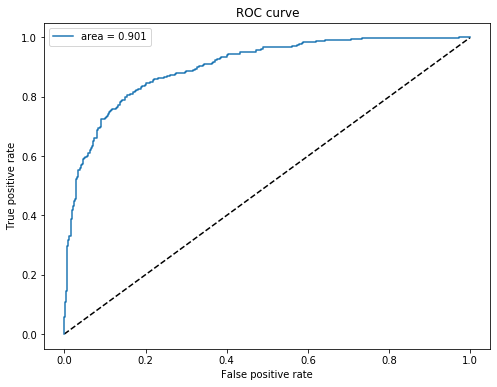

In [141]:
plot_roc_curve(dft['label'], dft['scratch_pred'])

### Create CNNs from Transfer Learning 

For this project I select three models available in Keras Applications: NasNetMobile, ResNet50V2 and DenseNet201. Those models were selected because other competitors on this Kaggle competition got good results wih them. When training this models the weights weren't initiated with the ImageNet validation dataset and the only modification was including the same final layer used on the scratch CNN we made previously. Everything else uses the same parameters and proccess. 

#### CNN using NASNetMobile

In [193]:
# Test for NASNet
base_model = NASNetMobile(input_shape = input_shape
                         ,include_top = False
                         ,weights = None)

# Include final fully connected layers
x = base_model.output
x = Flatten()(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(dense_dropout)(x)
x = Dense(units = final_units
         ,activation = "sigmoid")(x)

nn_model = Model(inputs = base_model.input
                ,outputs = x)

nn_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 47, 47, 32)   864         input_19[0][0]                   
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 47, 47, 32)   128         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation_3221 (Activation)    (None, 47, 47, 32)   0           stem_bn1[0][0]                   
____________________________________________________________________________________________

separable_conv_2_normal_right1_ (None, 6, 6, 88)     8536        activation_3318[0][0]            
__________________________________________________________________________________________________
separable_conv_2_normal_left2_6 (None, 6, 6, 88)     9944        activation_3320[0][0]            
__________________________________________________________________________________________________
separable_conv_2_normal_right2_ (None, 6, 6, 88)     8536        activation_3322[0][0]            
__________________________________________________________________________________________________
separable_conv_2_normal_left5_6 (None, 6, 6, 88)     8536        activation_3324[0][0]            
__________________________________________________________________________________________________
separable_conv_2_bn_normal_left (None, 6, 6, 88)     352         separable_conv_2_normal_left1_6[0
__________________________________________________________________________________________________
separable_

In [194]:
# Compile the model
nn_model.compile(optimizer = optimizers.Adam(learning_rate=0.001)
                ,loss = 'binary_crossentropy'
                ,metrics=['accuracy'])

# Prepare a check point to save the best model in the model folder
nn_checkpointer = ModelCheckpoint(filepath = os.path.join(model_folder,'nn_best.hdf5')
                                 ,verbose = 1
                                 ,save_best_only = True)

# Train the model
nn_history = nn_model.fit_generator(generator = train_generator
                                   ,shuffle = True
                                   ,epochs = 10
                                   ,steps_per_epoch = 100
                                   ,validation_data = valid_generator
                                   ,validation_steps = 30
                                   ,callbacks = [nn_checkpointer]
                                   ,verbose = 1)

Epoch 1/10
100/100 [==============================] - 243s 2s/step - loss: 0.6790 - accuracy: 0.7243 - val_loss: 5.2546 - val_accuracy: 0.5792

Epoch 00001: val_loss improved from inf to 5.25458, saving model to .\model\nn_best.hdf5
Epoch 2/10
100/100 [==============================] - 210s 2s/step - loss: 0.5757 - accuracy: 0.7522 - val_loss: 7.1707 - val_accuracy: 0.6104

Epoch 00002: val_loss did not improve from 5.25458
Epoch 3/10
100/100 [==============================] - 210s 2s/step - loss: 0.5514 - accuracy: 0.7772 - val_loss: 9.2554 - val_accuracy: 0.5917

Epoch 00003: val_loss did not improve from 5.25458
Epoch 4/10
100/100 [==============================] - 211s 2s/step - loss: 0.5064 - accuracy: 0.7798 - val_loss: 8.5587 - val_accuracy: 0.5851

Epoch 00004: val_loss did not improve from 5.25458
Epoch 5/10
100/100 [==============================] - 209s 2s/step - loss: 0.5673 - accuracy: 0.7776 - val_loss: 2.3968 - val_accuracy: 0.5823

Epoch 00005: val_loss improved from 5.

In [196]:
# Create the predictions for the test data
nn_prob = nn_model.predict_generator(generator = test_generator
                                    ,verbose = 1)

1000/1000 [==============================] - 65s 65ms/step


In [197]:
# Include the prediction column in the test dataframe
dfp = pd.DataFrame({'nn_pred': nn_prob[:,0]})
dft = pd.concat([dft,dfp], axis = 1)

In [198]:
# Quick look at our test dataframe
dft

,id,label,path,label_desc,nn_pred
0,aacd14eef69a8685afb5e87b2c78d45535d0c79f,0,.\test\aacd14eef69a8685afb5e87b2c78d45535d0c79...,False,0.053307
1,aa5044a6843c8ccdc6440629c9bfedff5e8df4d3,0,.\test\aa5044a6843c8ccdc6440629c9bfedff5e8df4d...,False,0.124727
2,aa7396a51f9796494654a8e96ba13374cc83b96d,0,.\test\aa7396a51f9796494654a8e96ba13374cc83b96...,False,0.072548
3,aa7814f917b987ee012314175623389f569c9eea,1,.\test\aa7814f917b987ee012314175623389f569c9ee...,True,0.160080
4,ab47cc369130b761b1409acccc52c1ff7ed298bd,1,.\test\ab47cc369130b761b1409acccc52c1ff7ed298b...,True,0.143229
...,...,...,...,...,...
995,ab3e25c7695fef6c466341188e8fea85704478a0,1,.\test\ab3e25c7695fef6c466341188e8fea85704478a...,True,0.115717
996,aa9dbca481b1089bdefc0e1716356f66cd4cea9d,1,.\test\aa9dbca481b1089bdefc0e1716356f66cd4cea9...,True,0.386481
997,aa081dd9815afecd4deb5132576c29d9255970bc,1,.\test\aa081dd9815afecd4deb5132576c29d9255970b...,True,0.156582
998,ab9bc9df8e07cad94feb22e2209b0ed53bfd3df7,0,.\test\ab9bc9df8e07cad94feb22e2209b0ed53bfd3df...,False,0.448942


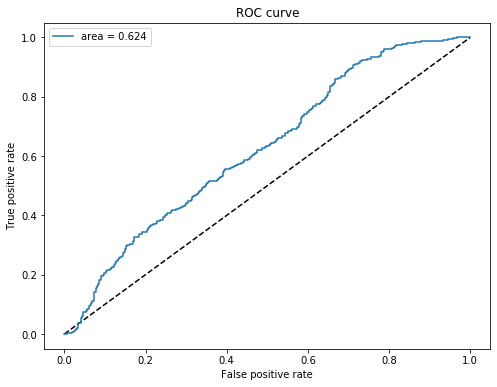

In [199]:
plot_roc_curve(dft['label'], dft['nn_pred'])

#### CNN using ResNet

In [200]:
# Transfer learning from ResNet50V2
base_model = ResNet50V2(input_shape = input_shape
                       ,include_top = False
                       ,weights = None)

# Include final fully connected layers
x = base_model.output
x = Flatten()(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(dense_dropout)(x)
x = Dense(units = final_units
         ,activation = "sigmoid")(x)

rn_model = Model(inputs = base_model.input
                ,outputs = x)

rn_model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 102, 102, 3)  0           input_20[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 48, 48, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 50, 50, 64)   0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [201]:
# Compile the model
rn_model.compile(optimizer = optimizers.Adam(learning_rate=0.001)
                ,loss = 'binary_crossentropy'
                ,metrics=['accuracy'])

# Prepare a check point to save the best model in the model folder
rn_checkpointer = ModelCheckpoint(filepath = os.path.join(model_folder,'rn_best.hdf5')
                                 ,verbose = 1
                                 ,save_best_only = True)

# Train the model
rn_history = rn_model.fit_generator(generator = train_generator
                                   ,shuffle = True
                                   ,epochs = 10
                                   ,steps_per_epoch = 100
                                   ,validation_data = valid_generator
                                   ,validation_steps = 30
                                   ,callbacks = [rn_checkpointer]
                                   ,verbose = 1)

Epoch 1/10
100/100 [==============================] - 581s 6s/step - loss: 0.8033 - accuracy: 0.7312 - val_loss: 0.9780 - val_accuracy: 0.4094

Epoch 00001: val_loss improved from inf to 0.97795, saving model to .\model\rn_best.hdf5
Epoch 2/10
100/100 [==============================] - 569s 6s/step - loss: 0.6498 - accuracy: 0.7622 - val_loss: 0.7506 - val_accuracy: 0.3969

Epoch 00002: val_loss improved from 0.97795 to 0.75063, saving model to .\model\rn_best.hdf5
Epoch 3/10
100/100 [==============================] - 563s 6s/step - loss: 0.6270 - accuracy: 0.7679 - val_loss: 0.6120 - val_accuracy: 0.4844

Epoch 00003: val_loss improved from 0.75063 to 0.61203, saving model to .\model\rn_best.hdf5
Epoch 4/10
100/100 [==============================] - 560s 6s/step - loss: 0.7006 - accuracy: 0.7794 - val_loss: 0.5854 - val_accuracy: 0.6576

Epoch 00004: val_loss improved from 0.61203 to 0.58543, saving model to .\model\rn_best.hdf5
Epoch 5/10
100/100 [==============================] - 56

In [202]:
# Create the predictions for the test data
rn_prob = rn_model.predict_generator(generator = test_generator
                                    ,verbose = 1)

# Include the prediction column in the test dataframe
dfp = pd.DataFrame({'rn_pred': rn_prob[:,0]})
dft = pd.concat([dft,dfp], axis = 1)

1000/1000 [==============================] - 203s 203ms/step


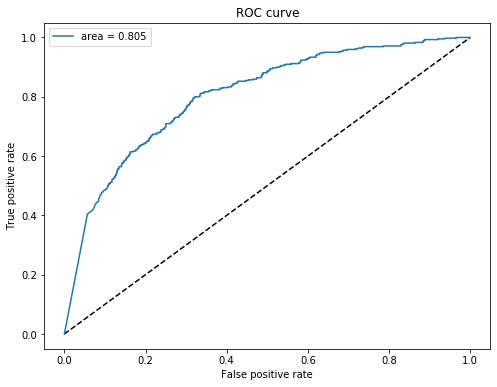

In [203]:
plot_roc_curve(dft['label'], dft['rn_pred'])

#### CNN using DenseNet

In [204]:
# Transfer learning from DenseNet201
base_model = DenseNet201(input_shape = input_shape
                        ,include_top = False
                        ,weights = None)

# Include final fully connected layers
x = base_model.output
x = Flatten()(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(dense_dropout)(x)
x = Dense(units = final_units
         ,activation = "sigmoid")(x)

dn_model = Model(inputs = base_model.input
                ,outputs = x)

dn_model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_73 (ZeroPadding2 (None, 102, 102, 3)  0           input_21[0][0]                   
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 48, 48, 64)   9408        zero_padding2d_73[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 48, 48, 64)   256         conv1/conv[0][0]                 
___________________________________________________________________________________________

conv4_block30_2_conv (Conv2D)   (None, 6, 6, 32)     36864       conv4_block30_1_relu[0][0]       
__________________________________________________________________________________________________
conv4_block30_concat (Concatena (None, 6, 6, 1216)   0           conv4_block29_concat[0][0]       
                                                                 conv4_block30_2_conv[0][0]       
__________________________________________________________________________________________________
conv4_block31_0_bn (BatchNormal (None, 6, 6, 1216)   4864        conv4_block30_concat[0][0]       
__________________________________________________________________________________________________
conv4_block31_0_relu (Activatio (None, 6, 6, 1216)   0           conv4_block31_0_bn[0][0]         
__________________________________________________________________________________________________
conv4_block31_1_conv (Conv2D)   (None, 6, 6, 128)    155648      conv4_block31_0_relu[0][0]       
__________

conv5_block8_concat (Concatenat (None, 3, 3, 1152)   0           conv5_block7_concat[0][0]        
                                                                 conv5_block8_2_conv[0][0]        
__________________________________________________________________________________________________
conv5_block9_0_bn (BatchNormali (None, 3, 3, 1152)   4608        conv5_block8_concat[0][0]        
__________________________________________________________________________________________________
conv5_block9_0_relu (Activation (None, 3, 3, 1152)   0           conv5_block9_0_bn[0][0]          
__________________________________________________________________________________________________
conv5_block9_1_conv (Conv2D)    (None, 3, 3, 128)    147456      conv5_block9_0_relu[0][0]        
__________________________________________________________________________________________________
conv5_block9_1_bn (BatchNormali (None, 3, 3, 128)    512         conv5_block9_1_conv[0][0]        
__________

In [205]:
# Compile the model
dn_model.compile(optimizer = optimizers.Adam(learning_rate=0.001)
                ,loss = 'binary_crossentropy'
                ,metrics=['accuracy'])

# Prepare a check point to save the best model in the model folder
dn_checkpointer = ModelCheckpoint(filepath = os.path.join(model_folder,'dn_best.hdf5')
                                 ,verbose = 1
                                 ,save_best_only = True)

# Train the model
dn_history = dn_model.fit_generator(generator = train_generator
                                   ,shuffle = True
                                   ,epochs = 10
                                   ,steps_per_epoch = 100
                                   ,validation_data = valid_generator
                                   ,validation_steps = 30
                                   ,callbacks = [dn_checkpointer]
                                   ,verbose = 1)

Epoch 1/10
100/100 [==============================] - 1083s 11s/step - loss: 0.7262 - accuracy: 0.7453 - val_loss: 1.0006 - val_accuracy: 0.4073

Epoch 00001: val_loss improved from inf to 1.00059, saving model to .\model\dn_best.hdf5
Epoch 2/10
100/100 [==============================] - 1067s 11s/step - loss: 0.6542 - accuracy: 0.7531 - val_loss: 0.7499 - val_accuracy: 0.5531

Epoch 00002: val_loss improved from 1.00059 to 0.74988, saving model to .\model\dn_best.hdf5
Epoch 3/10
100/100 [==============================] - 1054s 11s/step - loss: 0.7047 - accuracy: 0.7691 - val_loss: 1.0099 - val_accuracy: 0.5708

Epoch 00003: val_loss did not improve from 0.74988
Epoch 4/10
100/100 [==============================] - 1056s 11s/step - loss: 0.6821 - accuracy: 0.7909 - val_loss: 0.8419 - val_accuracy: 0.5462

Epoch 00004: val_loss did not improve from 0.74988
Epoch 5/10
100/100 [==============================] - 1051s 11s/step - loss: 0.6797 - accuracy: 0.7578 - val_loss: 3.7486 - val_accu

In [206]:
# Create the predictions for the test data
dn_prob = dn_model.predict_generator(generator = test_generator
                                    ,verbose = 1)

# Include the prediction column in the test dataframe
dfp = pd.DataFrame({'dn_pred': dn_prob[:,0]})
dft = pd.concat([dft,dfp], axis = 1)

1000/1000 [==============================] - 435s 435ms/step


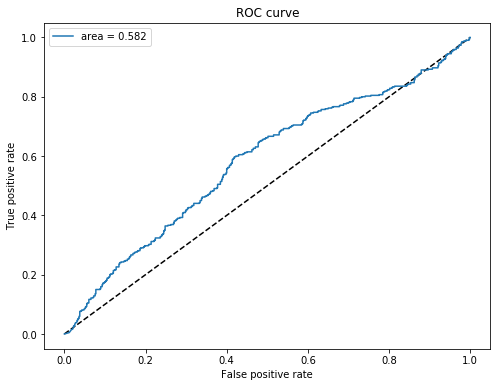

In [207]:
plot_roc_curve(dft['label'], dft['dn_pred'])

### Final Analysis

Here's the results from our models:

Model | AUC-ROC
---------|-----
Scratch CNN | 0.901
NasNetMobile | 0.624
ResNet50V2 | 0.805
DesneNet201 | 0.582

In this scenario the Scratch CNN got the best results. However this results may be influenced by the limits of my PC process power. We could probably get best results from the pre-trained models if given more time for training with more image samples, steps and epochs. Changing the image size to fit the size nedded to use the weights trained on the ImageNet for the pre-trained models could also improve the results. Others competitors achieved excellent results using more complex final layers at the end of the pre-trained models.

In a real world scenario were we use CNN for tumor predictions every improvement in the model is crucial. After all, we would be dealing with humans lifes and informing the diagnosis of a tumor cell could change lifes. So the time nedded to train a complex architecture CNN should be the minor of the problems. But for this project scenario with my limitations I'll stay with the Scratch CNN with it's simple, fast and good performance. 